# Example 1 Coin Flip

Here estimation of the probability of a binomial random process after $N$ trials will be estimated using Bayesian inference. This is a simple example that can be evaluated algebraically. This result will be compared with  the result obtained using pyMC. If $\theta$ is the binomial distribution parameter to be estimated and $Y$ the data to be analyzed then Bayes Theorem is defined by,

$
\begin{align}
P[\theta\, |\, Y] = \frac{P[Y\, | \,\theta] P[\theta]}{P[Y]}
\end{align}
\tag{1}
$

where $P[\theta\, |\, Y]$ is the posterior distribution, $P[Y\, | \,\theta]$ is the likelihood of the parameter estimate given the data, $P[\theta]$ is the prior distribution of the data and $P[Y]$ is the marginal likelihood which is given by,

$
\begin{align}
P[Y] = \int P[Y\, | \,\theta] P[\theta] d\theta = \int P[Y, \theta] d\theta
\end{align}
\tag{2}
$

The likelihood function is the Binomial distribution which is the probability $y$ heads after $N$ tosses,

$
\begin{align}
P[Y\, | \,\theta] = \frac{N!}{y!(N-y)!} \theta^y(1 - \theta)^{N-y}
\end{align}
\tag{3}
$

The prior distribution is the Beta distribution with parameters $\alpha$ and $\beta$ which is useful for modeling random variables with a range of $[0, 1]$,

$
\begin{align}
P[\theta] &= \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha) + \Gamma(\beta)} \theta^{\alpha-1}(1- \theta)^{\beta-1} \\
          &= \text{Beta}(\alpha, \beta)
\end{align}
\tag{4}
$

Where $\text{Beta}(\alpha, \beta)$ is the beta function with parameters $\alpha$ and $\beta$.
It is seen that $P[Y\, | \,\theta]$ and $P[\theta]$ have a similar form. It follows that the posterior distribution is given by,

$
\begin{align}
P[\theta\, |\, Y] &\propto \theta^y(1 - \theta)^{N-y} \theta^{\alpha-1}(1- \theta)^{\beta-1} \\
                  &= \text{Beta}(\alpha_{prior} + y, \beta_{prior} + N - y)
\end{align}
\tag{5}
$

In [109]:
%reload_ext autoreload
%autoreload 2

# import system modules and set local import path
import os
import sys
import numpy
from matplotlib import pyplot
from scipy import stats
import pymc
import arviz

sys.path.insert(0, os.path.abspath('../..'))

from lib import config
from lib.plots import (curve, comparison, bar, twinx_bar_line, fcurve_scatter_comparison, positive_negative_bar)

pyplot.style.use(config.glyfish_style)

In [74]:
def simulate_binomial_experiments(theta, N, nexp):
    data = numpy.random.binomial(1, theta, N)
    step = N / nexp
    exp_data = []
    for i in range(nexp):
        exp = data[:int((i + 1) * step)]
        heads = numpy.sum(exp)
        trials = len(exp)
        exp_data.append((heads, trials))
    return exp_data

def compute_posterior(beta_params, data):
    x = numpy.linspace(0, 1, 100)
    posteriors = []
    alpha, beta = beta_params
    for heads, trials in data:
        posterior = stats.beta(alpha + heads, beta + trials - heads).pdf(x)
        posteriors.append(posterior)
    return posteriors

def plot_posteriors(beta_params, data, theta):
    x = numpy.linspace(0, 1, 100)
    posteriors = compute_posterior(beta_params, data)

    title = f"Posterior Distributions\n$\\alpha_{{prior}}$={beta_params[0]}, $\\beta_{{prior}}$={beta_params[1]}, $\\theta$={theta}"
    labels = [f"$n_{{trials}}$={trials}, $n_{{heads}}$={heads}" for heads, trials in data]
    comparison(posteriors, x, ylabel='PDF', xlabel=f"$\\theta$", title=title, labels=labels)


def simulate_binomial(theta, N):
    samples = numpy.random.binomial(1, theta, N)
    heads = len(numpy.where(samples == 1)[0])
    tails = len(numpy.where(samples == 0)[0])
    return samples, heads, tails    


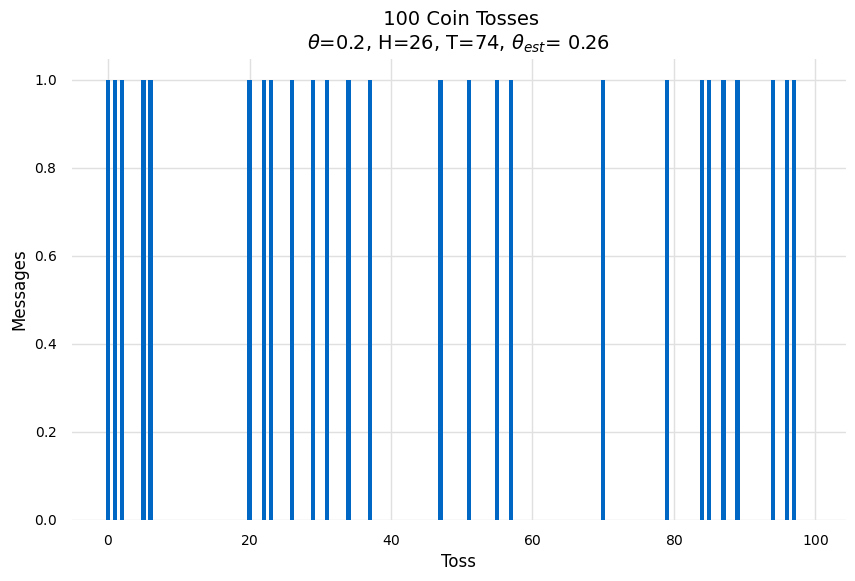

In [91]:
theta = 0.2
ntoss = 100
tau = 50
samples, heads, tails = simulate_binomial(theta, ntoss)

bar(samples, ylabel='Messages', xlabel='Toss', title=f"{ntoss: ,} Coin Tosses\n$\\theta$={theta}, H={heads}, T={tails}, $\\theta_{{est}}$={heads / ntoss: .2f}", alpha=1.0, bar_width=0.6)

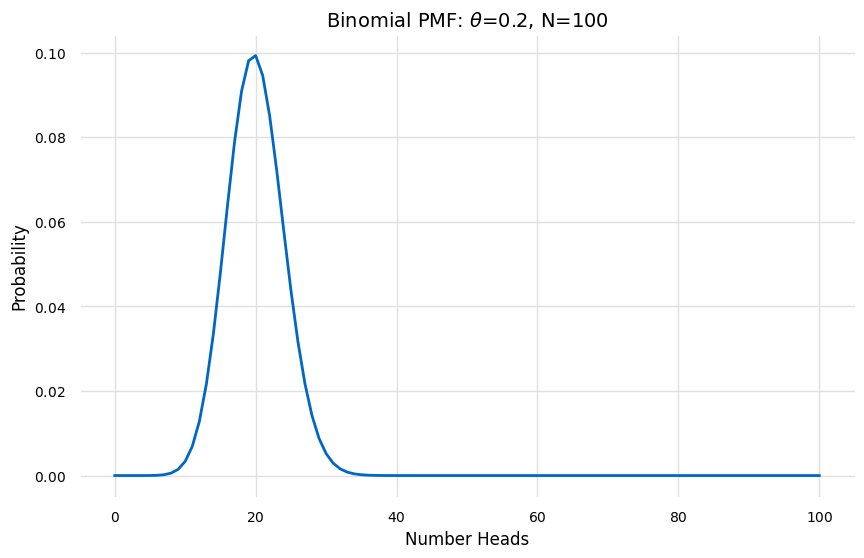

In [92]:
pmf = stats.binom.pmf(numpy.arange(0, ntoss + 1), ntoss, theta)
curve(pmf, ylabel='Probability', xlabel='Number Heads', title=f"Binomial PMF: $\\theta$={theta}, N={ntoss}")

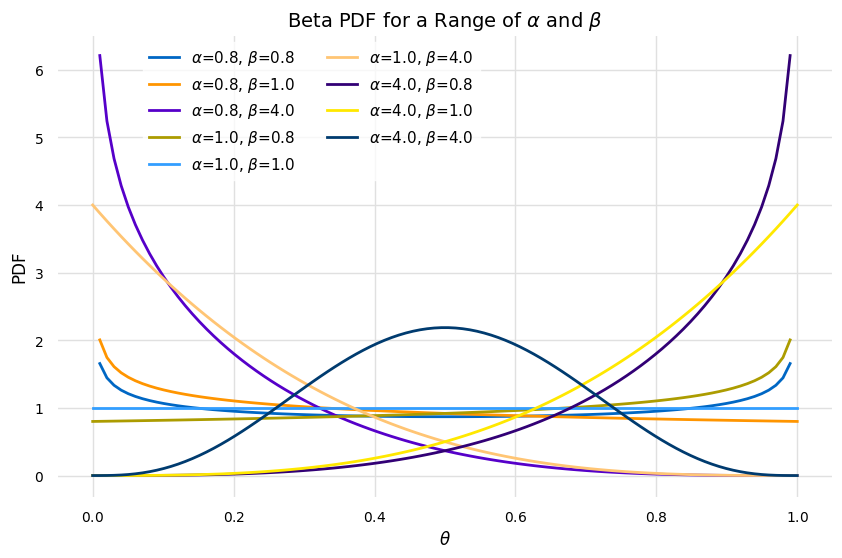

In [77]:

x = numpy.linspace(0, 1, 100)
alpha_vals = [0.8, 0.8, 0.8, 1.0, 1.0, 1.0, 4.0, 4.0, 4.0]
beta_vals = [0.8, 1.0, 4.0, 0.8, 1.0, 4.0, 0.8, 1.0, 4.0]
pdfs = [stats.beta.pdf(x, a, b) for a, b in zip(alpha_vals, beta_vals)]
labels = [f'$\\alpha$={a}, $\\beta$={b}' for a, b in zip(alpha_vals, beta_vals)]
comparison(pdfs, x, ylabel='PDF', xlabel=f"$\\theta$", title=f"Beta PDF for a Range of $\\alpha$ and $\\beta$", labels=labels)

## Examples of Posterior Distributions

Here examples of the posterior beta distribution with somewhat arbitrary parameter values of $\alpha_{prior}$ and $\beta_{prior}$ and data computed from a binomial distribution simulation with a specified value of $\theta$ and number of trails. It is seen that the choice of the prior parameters does not have much impact but the larger values perform a little better.

In [78]:
nexp = 4
beta_params = [(0.8, 1.0), (1.0, 4.0), (4.0, 4.0)]

data = simulate_binomial_experiments(theta, ntoss, nexp)

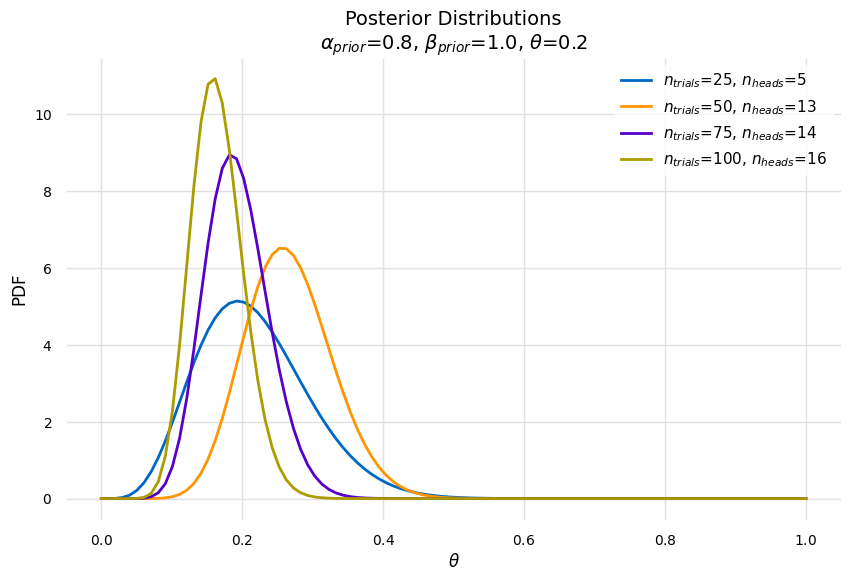

In [79]:
plot_posteriors(beta_params[0], data, theta)

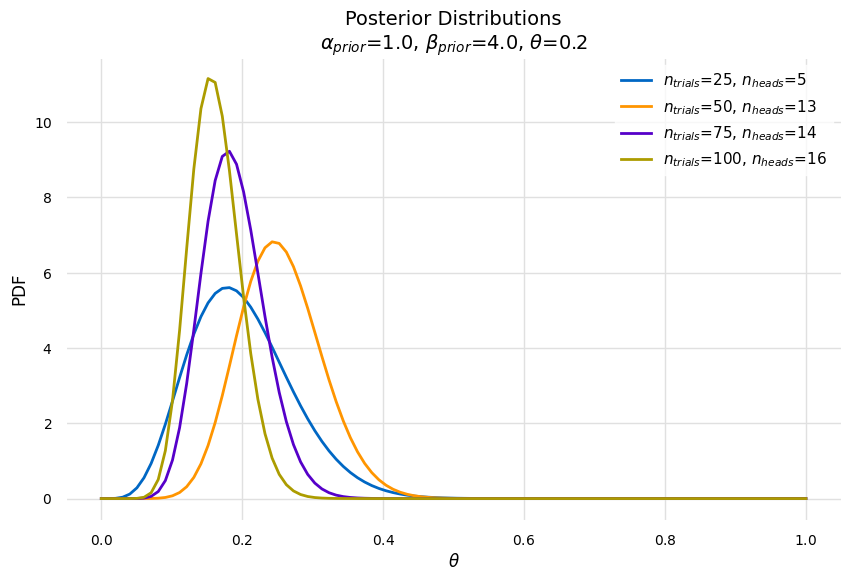

In [80]:
plot_posteriors(beta_params[1], data, theta)

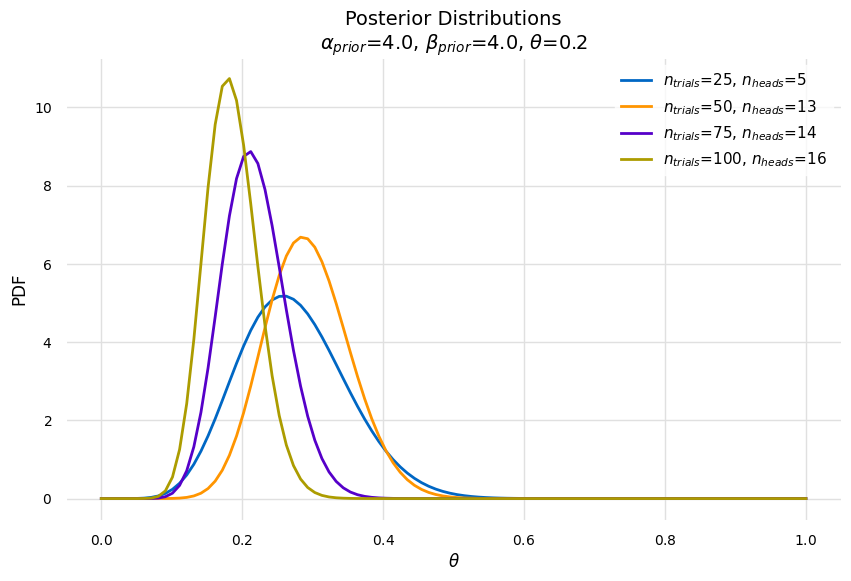

In [81]:
plot_posteriors(beta_params[2], data, theta)

## PyMC Simulation

In [164]:
ntrials = 50
theta_real = 0.35
alpha_prior = 1.0
beta_prior = 1.0
prior_vals = numpy.linspace(0, 1, 100)
nheads = numpy.arange(0, ntrials + 1)

samples, heads, tails = simulate_binomial(theta_real, ntrials)
prior_pdf = stats.beta.pdf(prior_vals, alpha_prior, beta_prior)
likelihood = stats.binom.pmf(nheads, ntrials, theta_real)

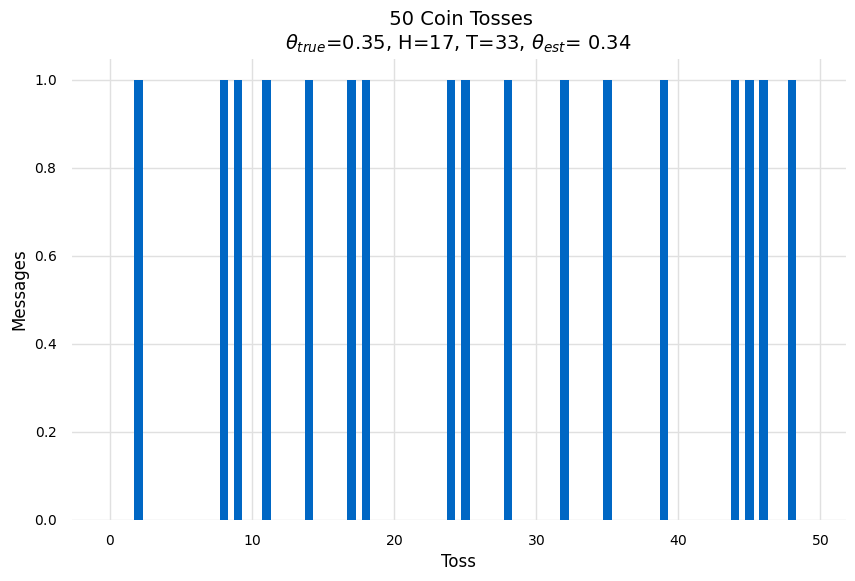

In [165]:
samples, heads, tails = simulate_binomial(theta_real, ntrials)
title = f"{ntrials: ,} Coin Tosses\n$\\theta_{{true}}$={theta_real}, H={heads}, T={tails}, $\\theta_{{est}}$={heads / ntrials: .2f}"

bar(samples, ylabel='Messages', xlabel='Toss', title=title, alpha=1.0, bar_width=0.6)

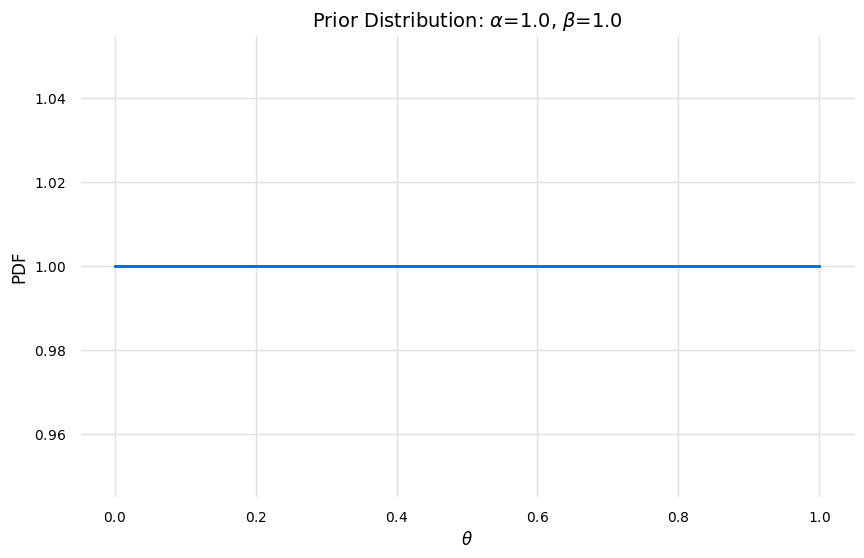

In [166]:
curve(prior_pdf, prior_vals, ylabel='PDF', xlabel='$\\theta$', title=f"Prior Distribution: $\\alpha$={alpha_prior}, $\\beta$={beta_prior}")

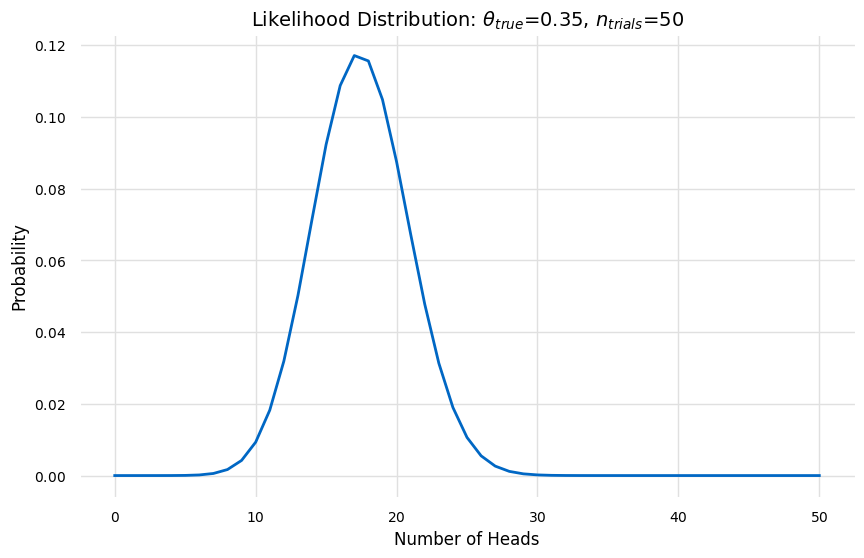

In [167]:
curve(likelihood, nheads, ylabel='Probability', xlabel='Number of Heads', title=f"Likelihood Distribution: $\\theta_{{true}}$={theta_real}, $n_{{trials}}$={ntrials}")

In [178]:
with pymc.Model() as model:
    p = pymc.Beta('θ', alpha=1, beta=1)
    y = pymc.Bernoulli('y', p=p, observed=samples)
    trace = pymc.sample(1000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>]],
      dtype=object)

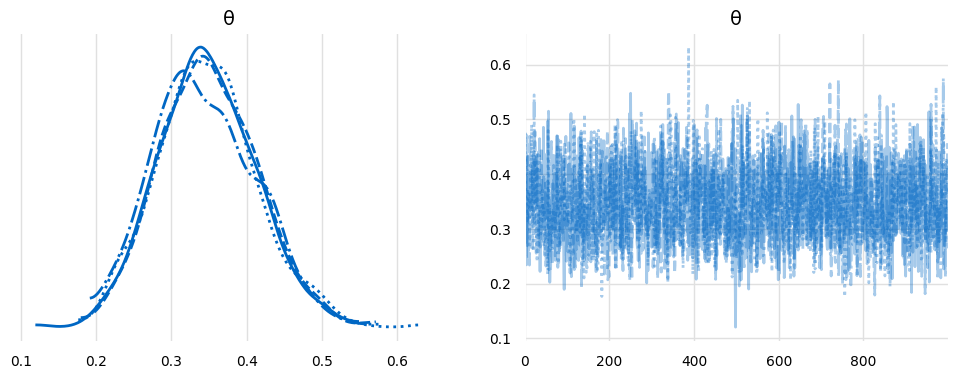

In [201]:
arviz.plot_trace(trace, figsize=(12, 4))

In [193]:
trace.posterior['θ'].values

array([[0.37479984, 0.45825182, 0.35563905, ..., 0.33545795, 0.33545795,
        0.34946069],
       [0.44417923, 0.47658853, 0.35570449, ..., 0.42530337, 0.38648146,
        0.36014181],
       [0.31583488, 0.26835658, 0.41322346, ..., 0.36022966, 0.37118692,
        0.45680099],
       [0.27717319, 0.27379515, 0.34508068, ..., 0.27216051, 0.27268152,
        0.42219797]])

array([[<Axes: title={'center': 'θ'}>,
        <Axes: title={'center': 'θ'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

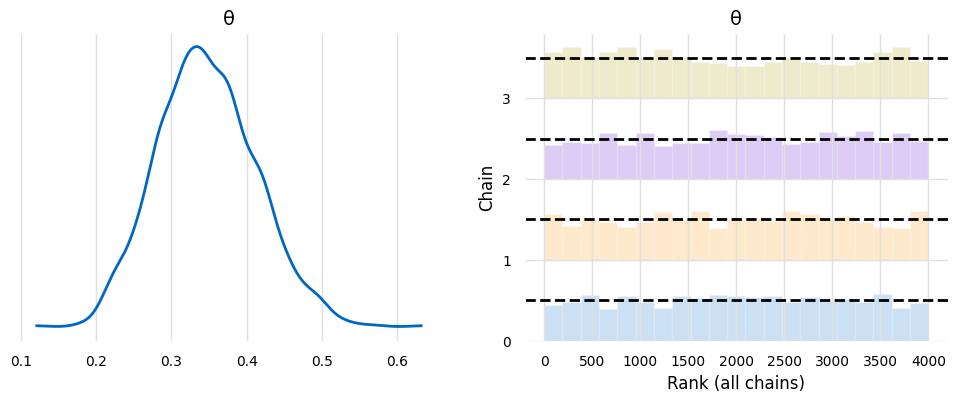

In [202]:
arviz.plot_trace(trace, kind='rank_bars', combined=True, figsize=(12, 4))

In [195]:
arviz.summary(trace, kind='stats').round(2)

,mean,sd,hdi_3%,hdi_97%
θ,0.35,0.06,0.22,0.46


<Axes: title={'center': 'θ'}>

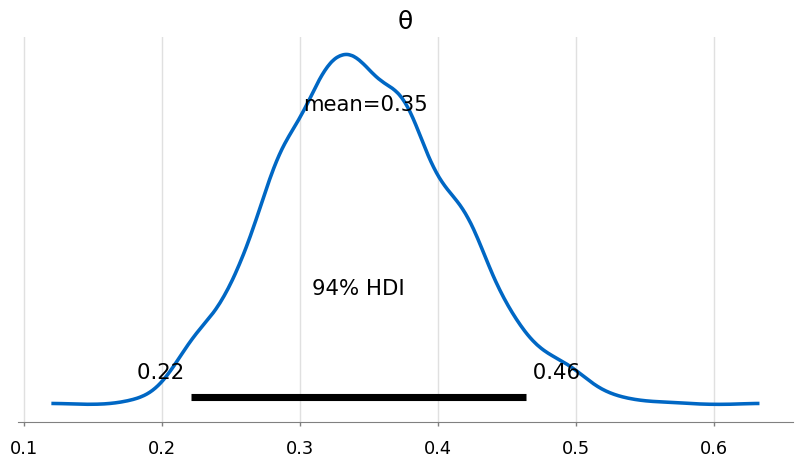

In [211]:
arviz.plot_posterior(trace, figsize=(10, 5))

({'BF10': 1.672164064303898, 'BF01': 0.5980274432080253},
 <Axes: title={'center': 'The BF_10 is 1.67\nThe BF_01 is 0.60'}, xlabel='θ', ylabel='Density'>)

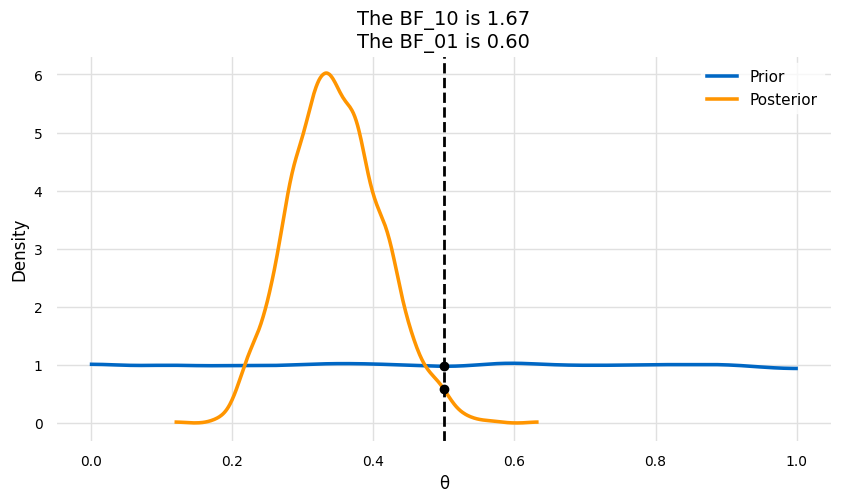

In [210]:
arviz.plot_bf(trace, var_name='θ', figsize=(10, 5), prior=numpy.random.uniform(0, 1, 10000), ref_val=0.5)

<Axes: title={'center': 'θ'}>

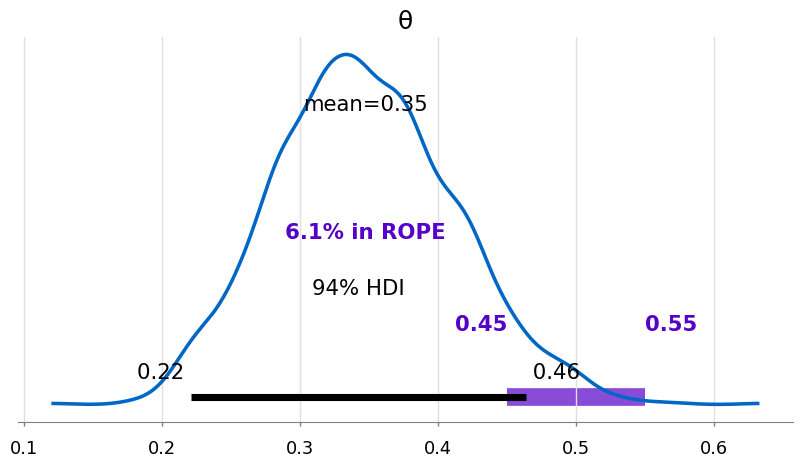

In [212]:
arviz.plot_posterior(trace, figsize=(10, 5), rope=[0.45, 0.55])

<Axes: title={'center': 'θ'}>

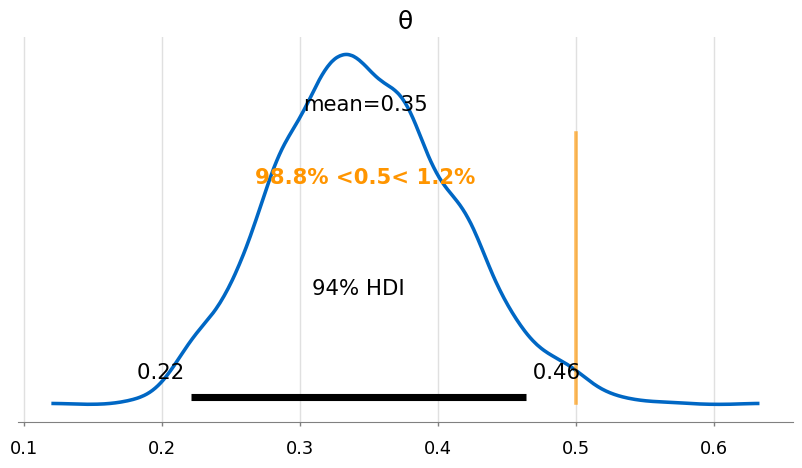

In [213]:
arviz.plot_posterior(trace, figsize=(10, 5), ref_val=0.5)